In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

real_data_path = '../../data/liver/liver_preprocessed.csv'
synth_data_path = '../../data/simulated/simulated_quality_check/train/'


def extract_histogram_split(sample_values, sample_labels, bins=30):
    """
    Compute 2 histograms for each sample:
    - one for elements where label == 1
    - one for elements where label == 0
    Concatenate the two histograms into a single vector and normalize by total count.
    """
    x_range = np.linspace(-4, 4, bins+1)
    vals_1 = sample_values[sample_labels == 1]
    vals_0 = sample_values[sample_labels == 0]
    hist1, _ = np.histogram(vals_1, bins=x_range)
    hist0, _ = np.histogram(vals_0, bins=x_range)
    hist = np.concatenate([hist1, hist0]).astype(float)
    if hist.sum() > 0:
        hist /= hist.sum()  # normalize to sum to 1
    return hist


analyte_dict = {
    'alanine aminotransferase': 'ALT',
    'albumin': 'ALB',
    'alkaline phosphatase': 'ALP',
    'aspartate aminotransferase': 'AST',
    'bilirubin': 'BIL',
    'cholesterol': 'CHOL',
    'cholinesterase': 'CHE',
    'creatinine': 'CREA',
    'gamma-glutamyl transferase': 'GGT',
    'total protein': 'PROT'
}

real_df = pd.read_csv(real_data_path)
f_data = real_df[real_df['gender'] == 'F'].iloc[:, 3:].to_numpy().T
m_data = real_df[real_df['gender'] == 'M'].iloc[:, 3:].to_numpy().T
real_arrays = list(f_data) + list(m_data)

# fixed boolean mask creation
f_labels = [real_df[real_df['gender'] == 'F']["label"].to_numpy()] * f_data.shape[0]
m_labels = [real_df[real_df['gender'] == 'M']["label"].to_numpy()] * m_data.shape[0]
labels_real = f_labels + m_labels
labels_real = [np.array(i) == 'reference' for i in labels_real]

real = real_arrays
del real_arrays, f_labels, m_labels, f_data, m_data
print(f"Real samples: {len(real)}")

synth = pickle.load(open(f"{synth_data_path}/input_data.pkl", "rb"))
labels_synth = pickle.load(open(f"{synth_data_path}/components.pkl", "rb"))
labels_synth = [np.array(i) == 0 for i in labels_synth]
print(f"Simulated samples: {len(synth)}")

# log and standardize
real, labels_real = zip(*[
    (x[~np.isnan(x)], lbl[~np.isnan(x)])
    for x, lbl in zip(real, labels_real)
    if np.sum(~np.isnan(x)) > 0  # keep only if at least one non-NaN
])
# convert back to lists
real = list(real)
labels_real = list(labels_real)
real = [np.log(i) for i in real]
# log_means, log_stds = [i.mean() for i in real], [i.std() for i in real]
real = [(i - i.mean())/i.std() for i in real]

synth_raw = synth.copy()
real_raw = real.copy()

# extract normalized histograms
real = [extract_histogram_split(i, j) for i, j in zip(real, labels_real)]
real = np.array(real).squeeze()
scaler = StandardScaler()
real_scaled = scaler.fit_transform(real)
print('Real data shape:\t', real.shape)

synth_lens = [len(i) for i in synth]
len_threshold = float('inf')
labels_synth = [i for i, j in zip(labels_synth, synth_lens) if j <= len_threshold]
synth = [i for i in synth if len(i) <= len_threshold]
synth = [extract_histogram_split(i, j) for i, j in zip(synth, labels_synth)]
synth = np.array(synth).squeeze()
synth_scaled = scaler.transform(synth)
print('Synth data shape:\t', synth.shape)

nn = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='euclidean')
nn.fit(synth_scaled)

distances, indices = nn.kneighbors(real_scaled)


Real samples: 20
Simulated samples: 10000
Real data shape:	 (20, 60)
Synth data shape:	 (10000, 60)


In [ ]:
# For each matched real–synthetic pair, compute L1, TV, and overlap
pair_L1 = []
pair_TV = []
pair_overlap = []

for i in range(len(real)):
    diff = np.abs(synth[indices[i][0]] - real[i])
    l1 = np.sum(diff)          # L1 distance
    tv = 0.5 * l1              # Total Variation
    overlap = 1.0 - tv         # Overlap = 1 - TV

    pair_L1.append(l1)
    pair_TV.append(tv)
    pair_overlap.append(overlap)

# Convert to numpy arrays if you like
pair_L1 = np.array(pair_L1)
pair_TV = np.array(pair_TV)
pair_overlap = np.array(pair_overlap)

# Averages
print(f"Average L1 distance: {pair_L1.mean():.4f}")
print(f"Average Total Variation distance: {pair_TV.mean():.4f}")
print(f"Average overlap (1 - TV): {pair_overlap.mean():.2%}")

# And you can now inspect per-pair values:
# print(pair_overlap)  # array of overlaps per real sample


Average L1 distance: 0.2981
Average Total Variation distance: 0.1491
Average overlap (1 - TV): 85.09%


In [ ]:
factor = synth.var(axis=0).mean() / real.var(axis=0).mean()
print(f"Synthetic variance is {factor:.2f}× the real variance.")
idx = np.where(np.array(synth_lens) <= 500)[0]
factor = synth[idx].var(axis=0).mean() / real.var(axis=0).mean()
print(f"Synthetic data of size <=500 variance is {factor:.2f}× the real variance.")


Synthetic variance is 2.25× the real variance.
Synthetic data of size <=500 variance is 2.25× the real variance.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X = np.vstack([real, synth])
y = np.r_[np.zeros(len(real)), np.ones(len(synth))]  # 0=real, 1=synth
clf = LogisticRegression(max_iter=1000)
auc = cross_val_score(clf, X, y, cv=5, scoring='roc_auc').mean()
print(f"Real vs synth separability AUC: {auc:.3f}  (0.5 ~ indistinguishable)")


Real vs synth separability AUC: 0.580  (0.5 ~ indistinguishable)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X = np.vstack([real_scaled, synth_scaled])
y = np.r_[np.zeros(len(real)), np.ones(len(synth))]  # 0=real, 1=synth
clf = LogisticRegression(max_iter=1000)
auc = cross_val_score(clf, X, y, cv=5, scoring='roc_auc').mean()
print(f"Real vs synth separability AUC: {auc:.3f}  (0.5 ~ indistinguishable)")


Real vs synth separability AUC: 0.834  (0.5 ~ indistinguishable)


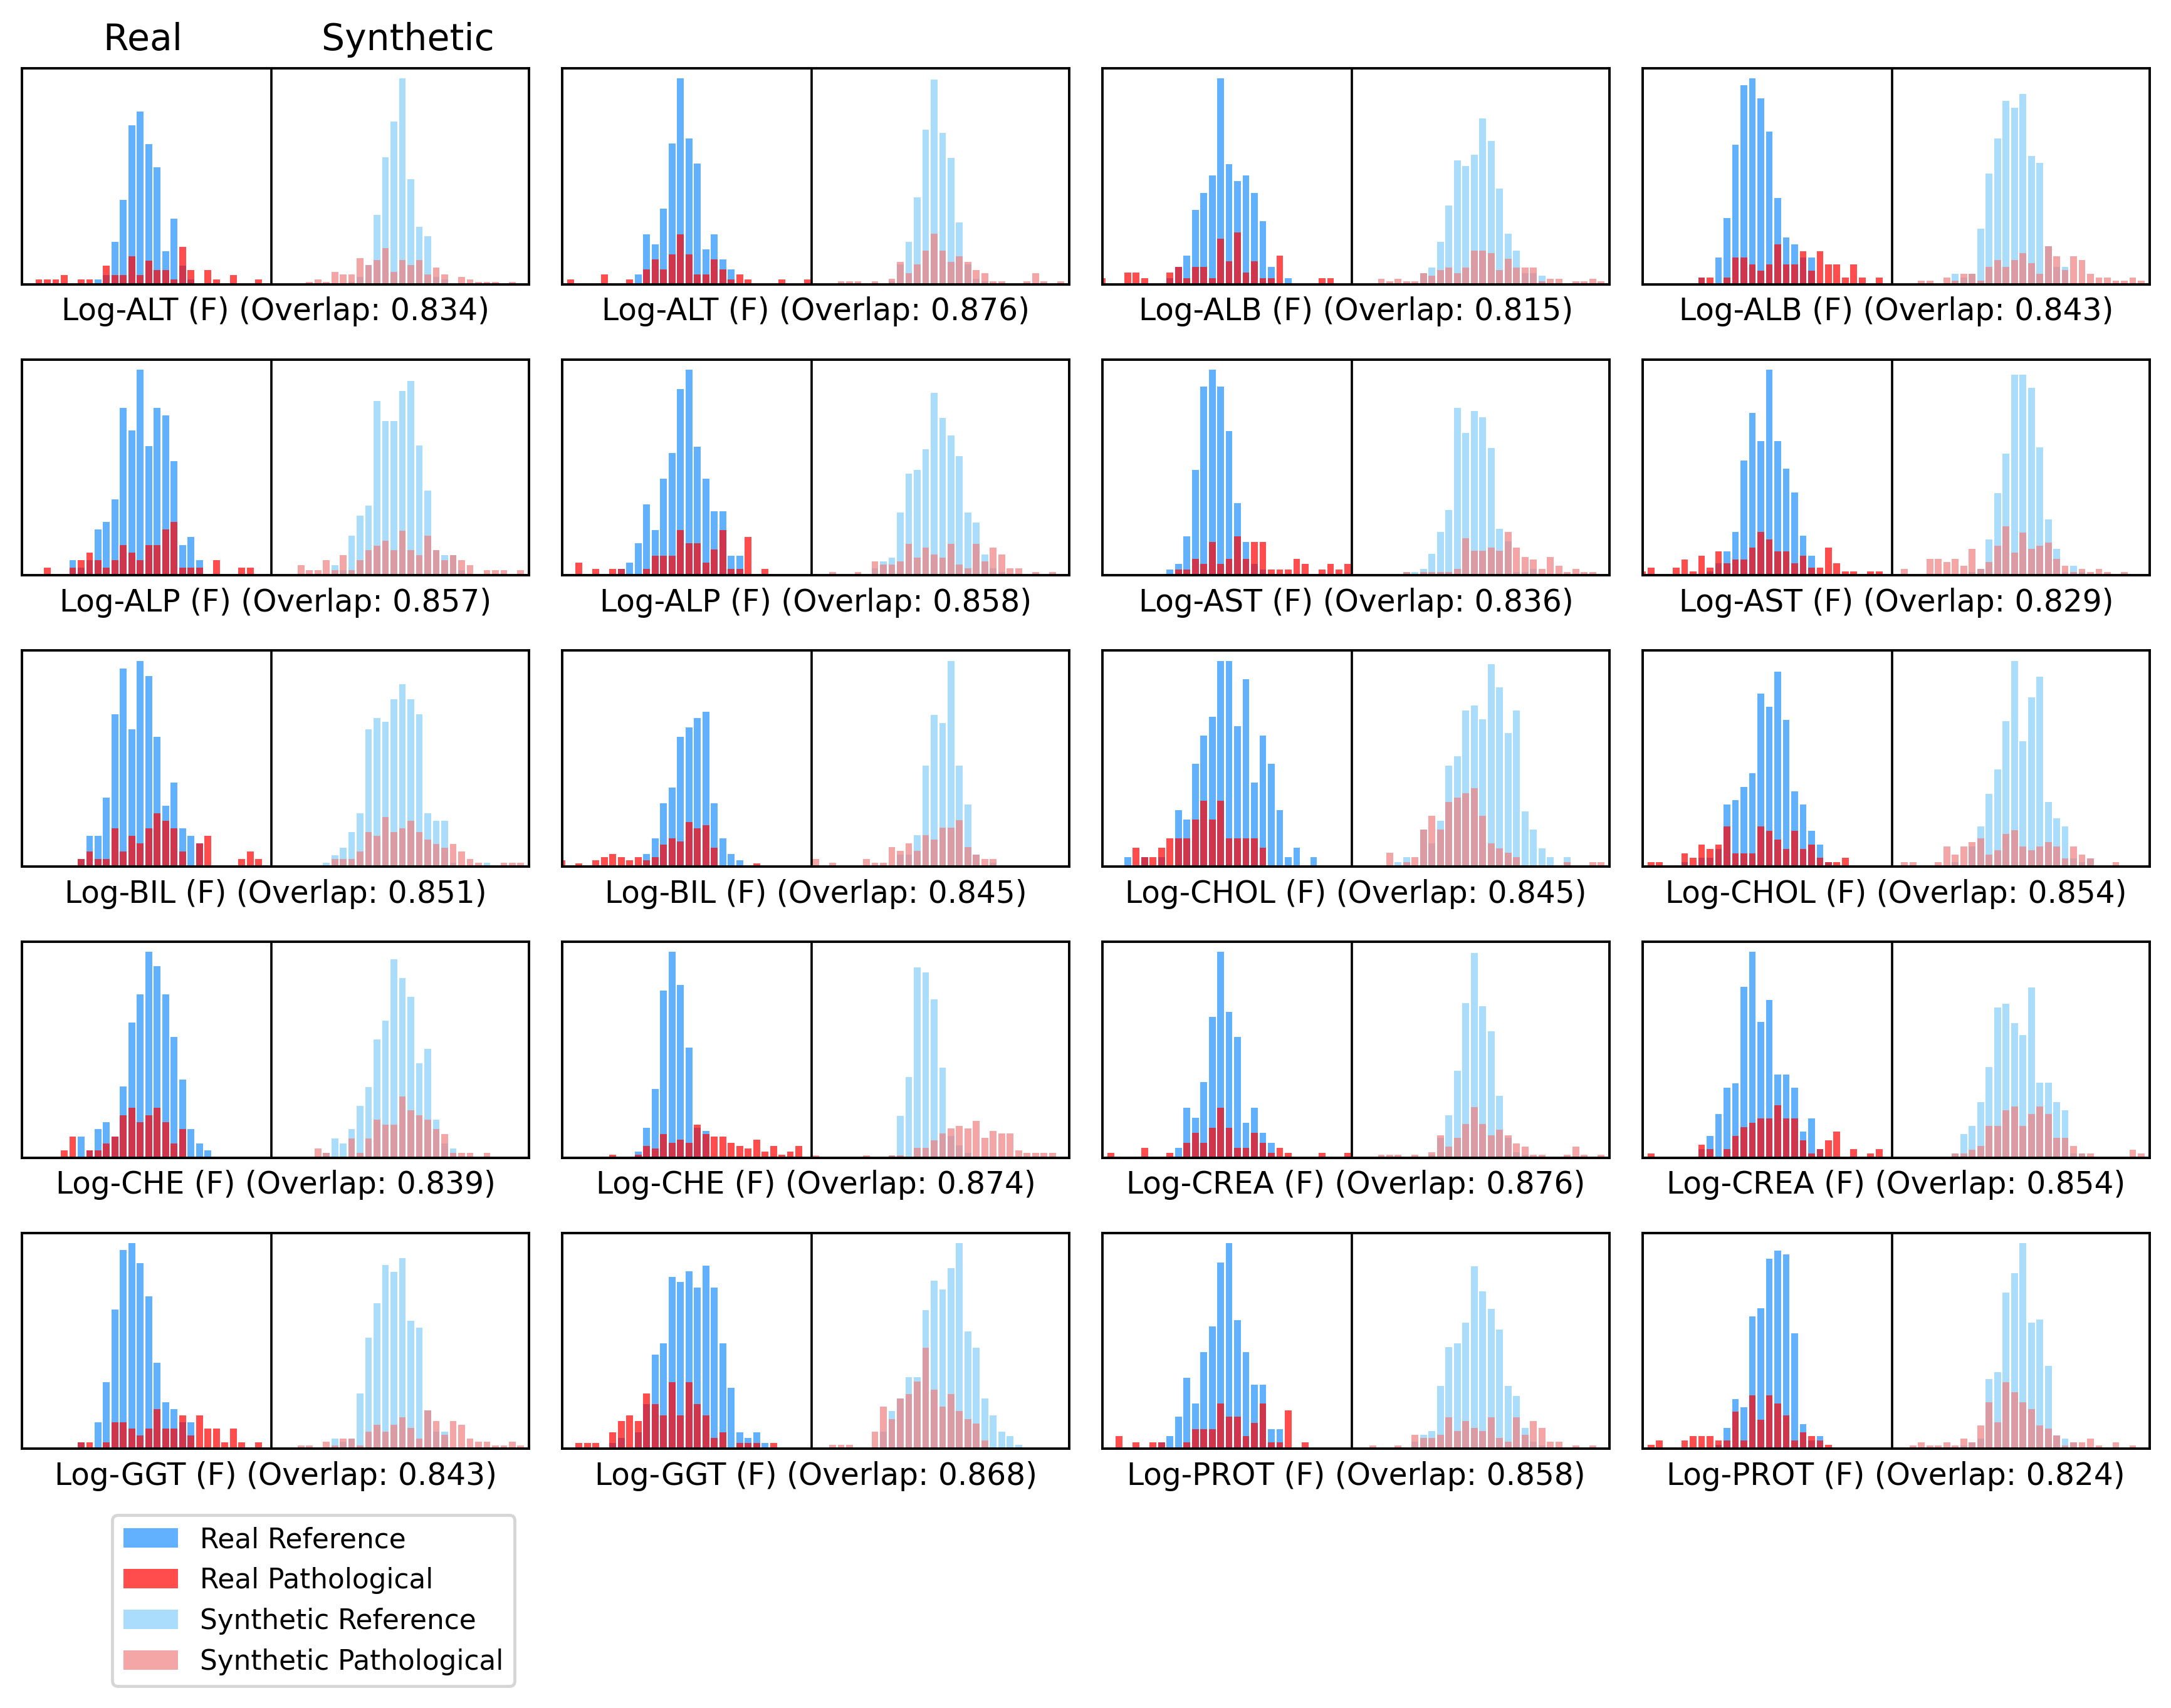

In [ ]:
hist_nbins = real.shape[1]
mid = hist_nbins // 2  # to split ref vs Pathological *within each histogram*
analytes = list(analyte_dict.keys())
nr = 5
nc = 4
plt.figure(figsize=(10, 7), dpi=350)
c = 0

for n, i in enumerate(range(10)):
    # --- Female subplot ---
    c += 1
    ax = plt.subplot(nr, nc, c)

    real_i = real[i]
    synth_i = synth[indices[i, 0]]
    # synth_i = synth[i]

    x_real = np.arange(mid)             # bins for left side
    x_synth = np.arange(mid, 2*mid)     # bins for right side

    # plot REAL on left side
    ax.bar(x_real, real_i[:mid], color='dodgerblue', alpha=0.7, label='Real ref')
    ax.bar(x_real, real_i[mid:], color='red', alpha=0.7, label='Real abn')

    # plot SYNTH on right side
    ax.bar(x_synth, synth_i[:mid], color='lightskyblue', alpha=0.7, label='Synthetic ref')
    ax.bar(x_synth, synth_i[mid:], color='lightcoral', alpha=0.7, label='Synth abn')

    ax.axvline(mid-0.5, c='k', linewidth=0.75)  # divider between real/synth
    ax.set_xlim(0, 2*mid)  # ensure both halves show

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('Log-' + analyte_dict[analytes[n]] +
                  ' (F) (Overlap: ' + str(round(pair_overlap[i], 3)) + ')')
    if i == 0:
        ax.set_title("    Real            Synthetic")

    # --- Male subplot ---
    c += 1
    ax = plt.subplot(nr, nc, c)

    real_i = real[i+7]
    synth_i = synth[indices[i+7, 0]]
    # synth_i = synth[i+1]

    # same x ranges
    ax.bar(x_real, real_i[:mid], color='dodgerblue', alpha=0.7, label='Real Reference')
    ax.bar(x_real, real_i[mid:], color='red', alpha=0.7, label='Real Pathological')
    ax.bar(x_synth, synth_i[:mid], color='lightskyblue', alpha=0.7, label='Synthetic Reference')
    ax.bar(x_synth, synth_i[mid:], color='lightcoral', alpha=0.7, label='Synthetic Pathological')

    ax.axvline(mid-0.5, c='k', linewidth=0.75)
    ax.set_xlim(0, 2*mid)

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('Log-' + analyte_dict[analytes[n]] +
                  ' (F) (Overlap: ' + str(round(pair_overlap[i+7], 3)) + ')')

# Add legend 
handles, labels = plt.gca().get_legend_handles_labels()
# place legend to the right of all subplots
plt.gcf().legend(handles, labels,
                 loc="center left",     # position relative to bbox_to_anchor
                 bbox_to_anchor=(0.05, -0.05),  # (x, y) relative to figure
                 fontsize=9)

plt.tight_layout()
plt.savefig('./synth_nn_check_side_by_side.png', bbox_inches='tight')


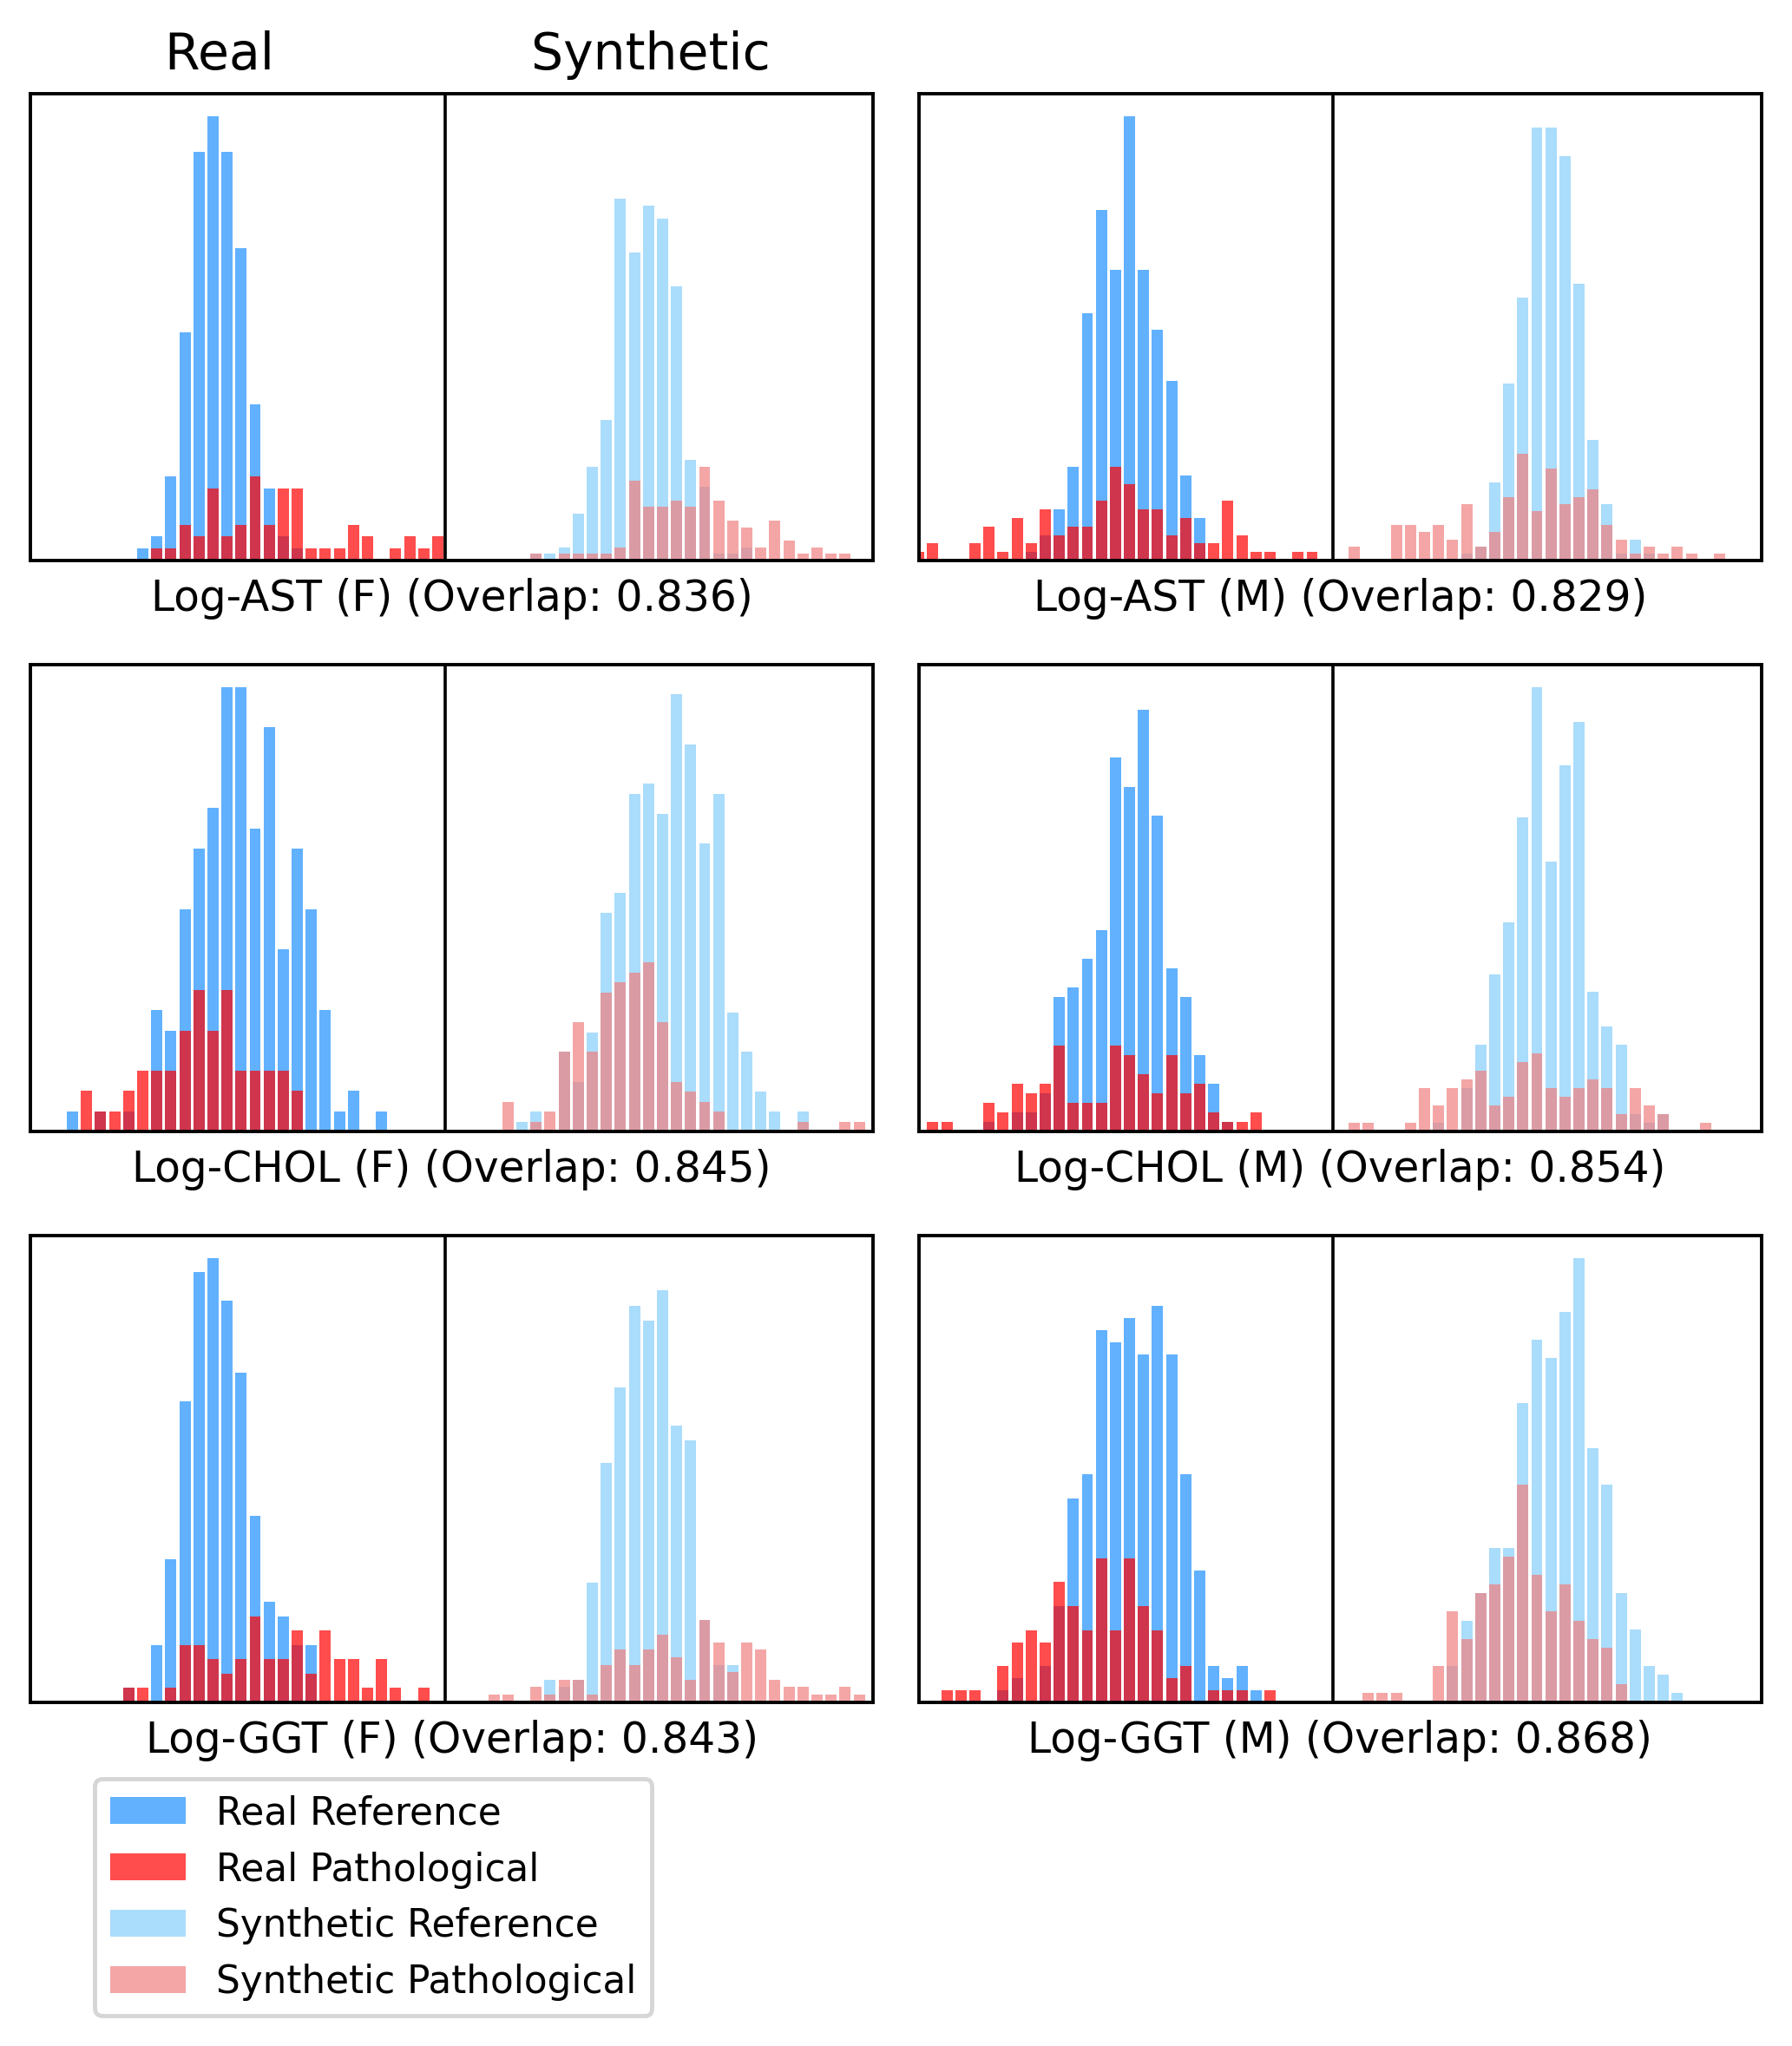

In [ ]:
# Specify which analytes you want to plot
selected_analytes = ["AST", "CHOL", "GGT"]  # <- update this list

hist_nbins = real.shape[1]
mid = hist_nbins // 2
analytes = list(analyte_dict.keys())

# Map short names back to index positions
selected_indices = [analytes.index(full_name) for full_name, short in analyte_dict.items()
                    if short in selected_analytes]

nr = len(selected_indices)
nc = 2  # one col for female, one for male
plt.figure(figsize=(6, 2 * nr), dpi=350)

for row, idx in enumerate(selected_indices):
    # --- Female subplot (left col) ---
    ax = plt.subplot(nr, nc, 2*row + 1)

    real_i = real[idx]
    synth_i = synth[indices[idx, 0]]
    x_real = np.arange(mid)
    x_synth = np.arange(mid, 2*mid)

    ax.bar(x_real, real_i[:mid], color='dodgerblue', alpha=0.7, label='Real Reference')
    ax.bar(x_real, real_i[mid:], color='red', alpha=0.7, label='Real Pathological')
    ax.bar(x_synth, synth_i[:mid], color='lightskyblue', alpha=0.7, label='Synth. Reference')
    ax.bar(x_synth, synth_i[mid:], color='lightcoral', alpha=0.7, label='Synth. Pathological')

    ax.axvline(mid-0.5, c='k', linewidth=0.75)
    ax.set_xlim(0, 2*mid)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel(f"Log-{analyte_dict[analytes[idx]]} (F) (Overlap: {pair_overlap[idx]:.3f})")
    if row == 0:
        ax.set_title("  Real                Synthetic")
        # ax.set_title("Test")

    # --- Male subplot (right col) ---
    ax = plt.subplot(nr, nc, 2*row + 2)

    real_i = real[idx+7]
    synth_i = synth[indices[idx+7, 0]]

    ax.bar(x_real, real_i[:mid], color='dodgerblue', alpha=0.7, label='Real Reference')
    ax.bar(x_real, real_i[mid:], color='red', alpha=0.7, label='Real Pathological')
    ax.bar(x_synth, synth_i[:mid], color='lightskyblue', alpha=0.7, label='Synthetic Reference')
    ax.bar(x_synth, synth_i[mid:], color='lightcoral', alpha=0.7, label='Synthetic Pathological')

    ax.axvline(mid-0.5, c='k', linewidth=0.75)
    ax.set_xlim(0, 2*mid)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel(f"Log-{analyte_dict[analytes[idx]]} (M) (Overlap: {pair_overlap[idx+7]:.3f})")

# Add legend 
handles, labels = plt.gca().get_legend_handles_labels()
# place legend to the right of all subplots
plt.gcf().legend(handles, labels,
                 loc="center left",     # position relative to bbox_to_anchor
                 bbox_to_anchor=(0.05, -0.05),  # (x, y) relative to figure
                 fontsize=9)

plt.tight_layout()
plt.savefig('./synth_nn_check_selected.png', bbox_inches="tight")
